In [1]:
ssm_full_grid_file = "/home/benr/wqmodels/SSMC_Share/SSM_Grid/Salish_Sea_Shelf_top_0.2_DZ_10_3_16.2dm"
do_data_cdf = "/home/benr/wqmodels/dopca/bottom do 2008.nc"
domain_out_shp = "ssm filled domain nodes.shp"

from netCDF4 import Dataset
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
do_data = Dataset(do_data_cdf)
do_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8760), node(6120)
    variables(dimensions): int32 node(node), float32 existing(time, node), float32 reference(time, node)
    groups: 

In [3]:
dodeltas = (do_data['existing'][:].data - do_data['reference'][:].data)
dodeltas.shape

(8760, 6120)

,node_id,depth,geometry,values
0,4369,45.183998,"POLYGON ((515282.150 5333310.800, 514957.767 5...",-0.009180
1,4370,51.813999,"POLYGON ((515087.250 5334738.350, 515039.410 5...",-0.013920
2,4371,51.813999,"POLYGON ((515720.085 5336024.300, 515678.443 5...",-0.019120
3,4372,55.544998,"POLYGON ((516396.973 5336859.567, 516347.240 5...",-0.021950
4,4373,60.431000,"POLYGON ((517118.153 5338021.300, 517127.570 5...",-0.020410
...,...,...,...,...
6115,16008,4.000000,"POLYGON ((498376.500 5233366.350, 498427.753 5...",-0.031700
6116,16009,4.000000,"POLYGON ((498243.753 5233618.233, 498318.630 5...",-0.037601
6117,16010,4.000000,"POLYGON ((497830.500 5233620.000, 498107.000 5...",-0.034400
6118,16011,4.000000,"POLYGON ((498793.630 5233760.500, 498766.087 5...",-0.029201


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
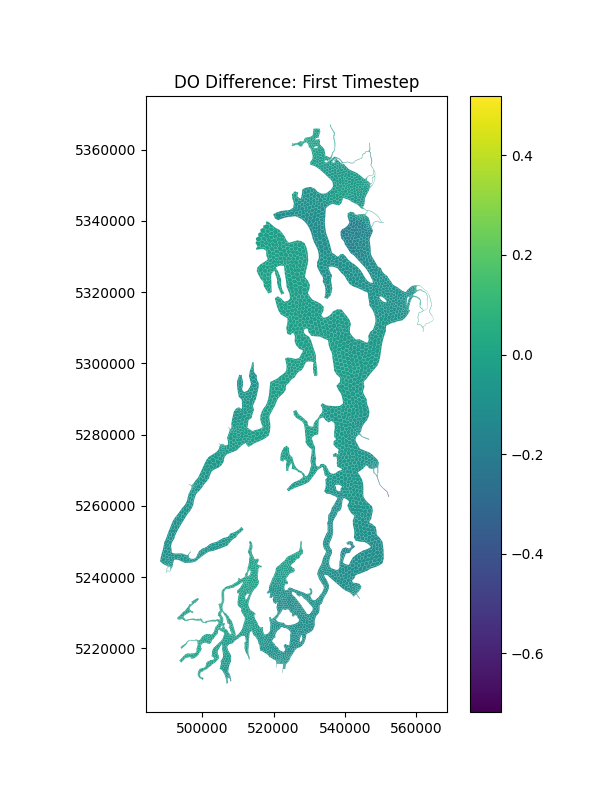

In [38]:
domain = gpd.read_file(domain_out_shp)
times = np.arange(do_data.dimensions['time'].size)

def do_plot(vals, title, ax=None):
    copy = domain.copy()
    copy['values'] = vals
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8))
    p = copy.plot('values', ax=ax, markersize=1, legend=True)
    ax.set_title(title)
    ax.ticklabel_format(style='plain')
    return copy

do_plot(dodeltas[0,:], "DO Difference: First Timestep")

In [35]:
# Calculate a spatial weight for each node
weights = domain['geometry'].area.to_numpy() * domain['depth'].to_numpy()
weights /= weights.sum()

X = dodeltas * weights
nPoints = dodeltas.shape[1]
Xavg = np.mean(X,axis=1)                  # Compute mean
B = X - np.tile(Xavg,(nPoints,1)).T       # Mean-subtracted data

U, S, V = np.linalg.svd(B / np.sqrt(nPoints), full_matrices=False)
U.shape, S.shape, V.shape

((8760, 6120), (6120,), (6120, 6120))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
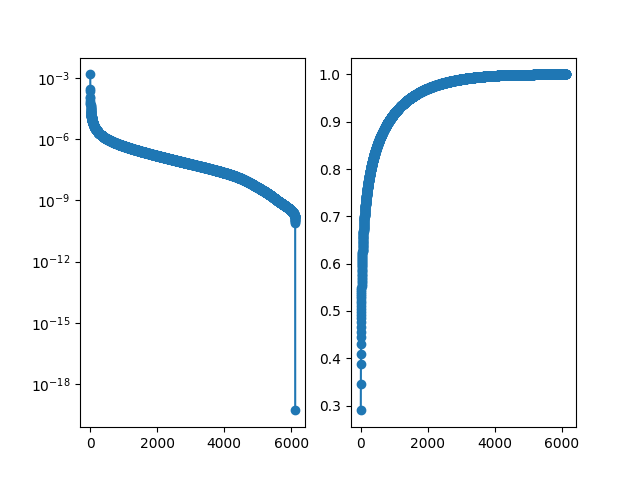

In [36]:
fig, axs = plt.subplots(1, 2)
axs[0].semilogy(S, '-o')
axs[1].plot(np.cumsum(S)/np.sum(S),'-o')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
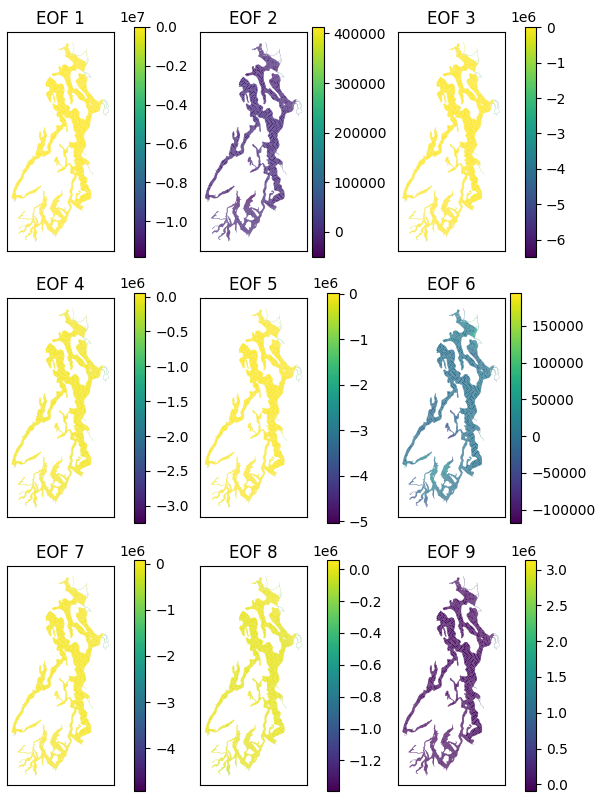

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
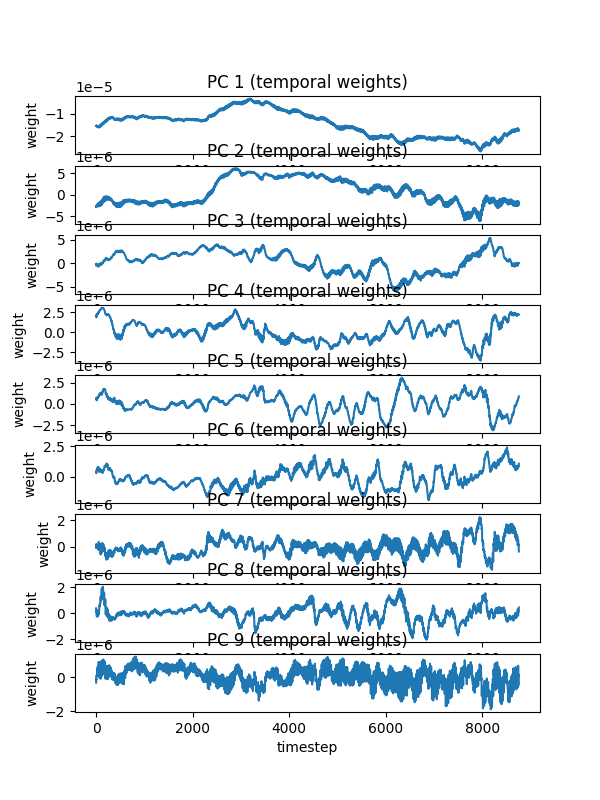

In [49]:
eofs = 9

eoffig, eofaxs = plt.subplots(int(eofs/3), 3, figsize=(6, 8), constrained_layout=True)
pcfig, pcaxs = plt.subplots(eofs, 1, figsize=(6, 8))

for i, (eofax, pcax) in enumerate(zip(np.array(eofaxs).flatten(), np.array(pcaxs).flatten())):
    do_plot(V[i,:]*np.sqrt(nPoints)/weights, "EOF {0}".format(i+1), ax=eofax)
    eofax.set_xticks([])
    eofax.set_yticks([])

    pcax.plot(times,U[:,i]*S[i])
    pcax.set(title='PC {0} (temporal weights)'.format(i+1), xlabel='timestep', ylabel='weight')

Text(0, 0.5, 'weight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
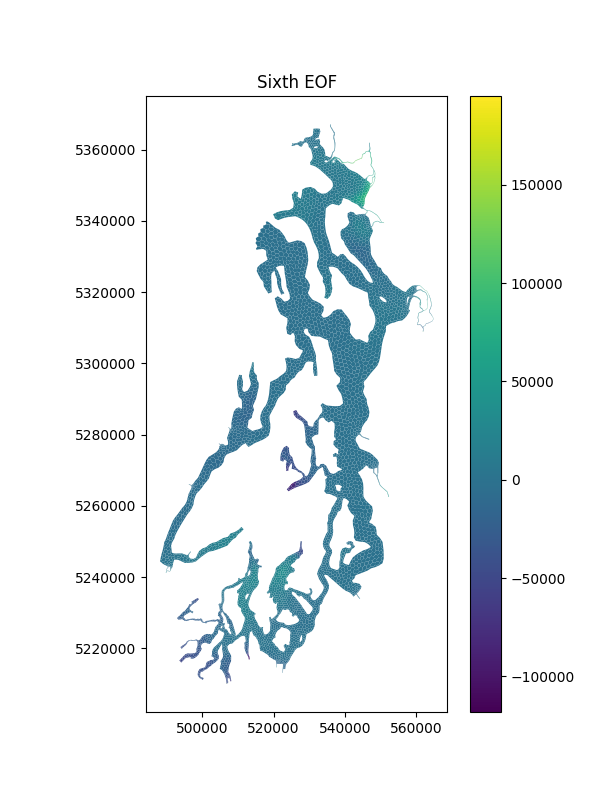

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
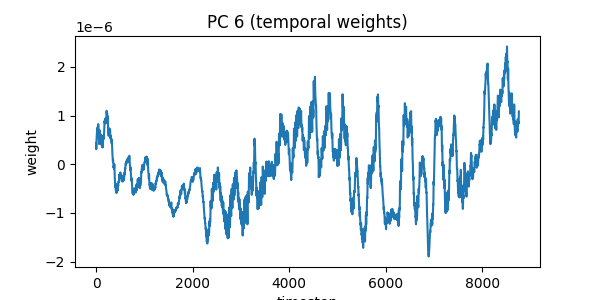

In [50]:
do_plot(V[5,:]*np.sqrt(nPoints)/weights, "Sixth EOF")

plt.figure(figsize=(6,3))
plt.plot(times,U[:,5]*S[5])
plt.title('PC 6 (temporal weights)')
plt.xlabel('timestep')
plt.ylabel('weight')

Text(0, 0.5, 'weight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
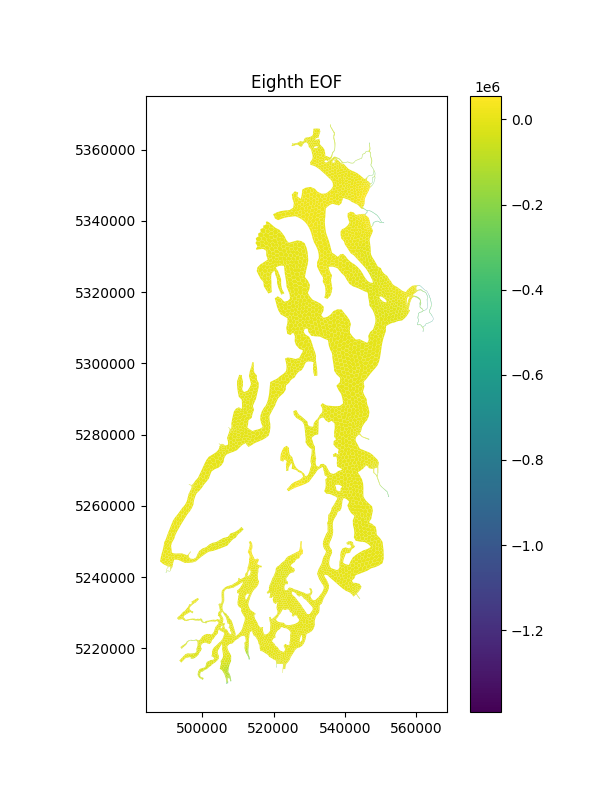

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
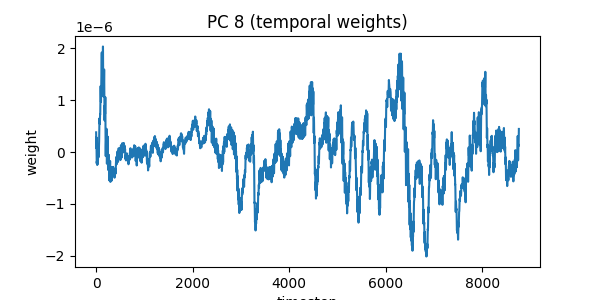

In [51]:
do_plot(V[7,:]*np.sqrt(nPoints)/weights, "Eighth EOF")

plt.figure(figsize=(6,3))
plt.plot(times,U[:,7]*S[7])
plt.title('PC 8 (temporal weights)')
plt.xlabel('timestep')
plt.ylabel('weight')

Text(0, 0.5, 'weight')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
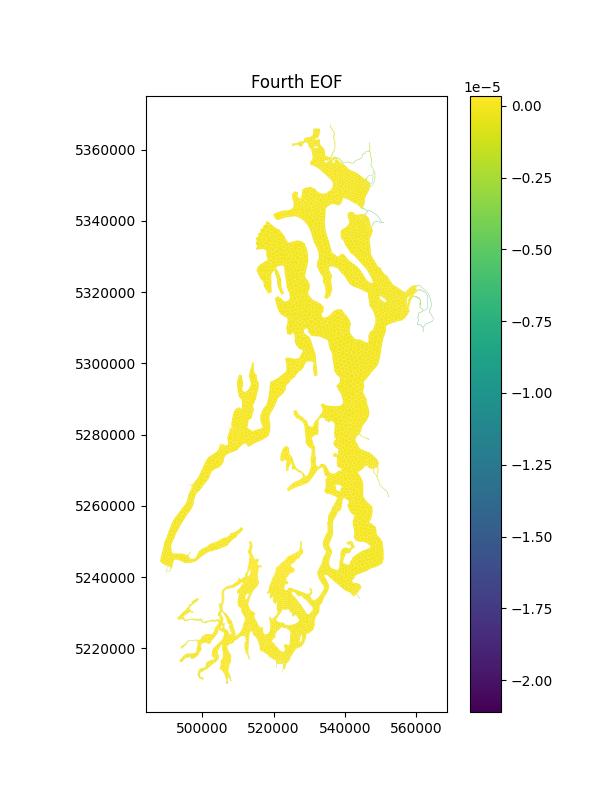

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
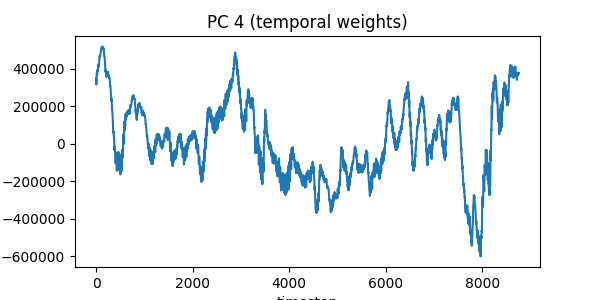

In [32]:
do_plot(V[3,:]*np.sqrt(nPoints)/weights, "Fourth EOF")

plt.figure(figsize=(6,3))
plt.plot(times,U[:,3]*S[3])
plt.title('PC 4 (temporal weights)')
plt.xlabel('timestep')
plt.ylabel('weight')